# "Laplacian Matrix Learning for Smooth Graph Signal Representation" [Dong et al., 2015]

In [125]:
from scipy import spatial
from sklearn import metrics
import pygsp
import utils
import learn_graph as lg
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

## Generate ground truth graph

In [126]:
N = 256 # Number of nodes
Ne = (N * (N - 1)) // 2 # number of edges

G = pygsp.graphs.Sensor(N)
# G = pygsp.graphs.DavidSensorNet(N)
W_gt = G.W.toarray()
pos = G.coords
G_nx = nx.from_numpy_matrix(W_gt)

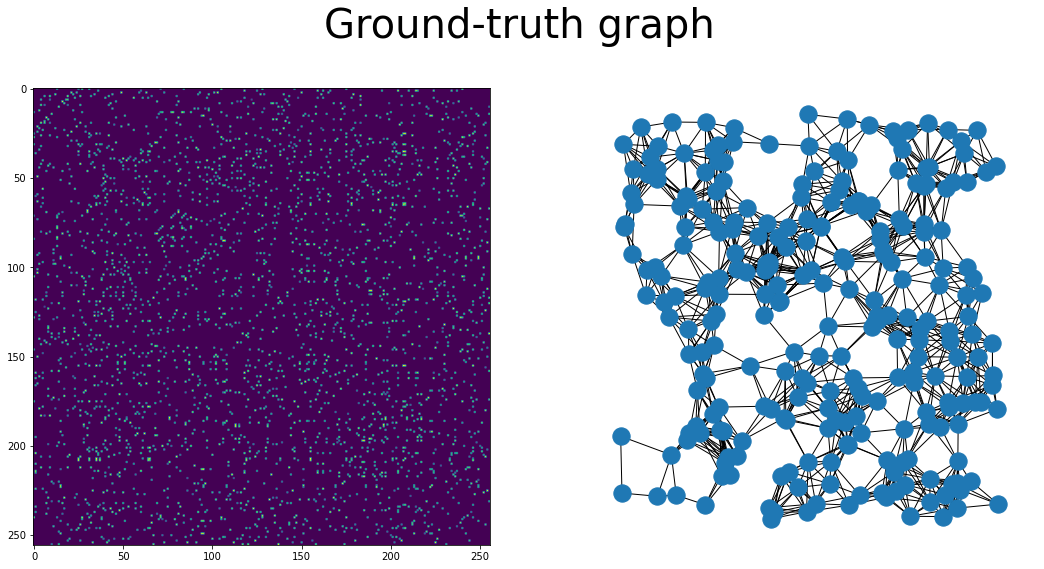

In [127]:
plt.figure(figsize=(18, 9))
plt.suptitle('Ground-truth graph', fontsize=40)

plt.subplot(1,2,1)
plt.imshow(W_gt)

plt.subplot(1,2,2)
nx.draw(G_nx, pos=pos)

## Generate samples

In [128]:
def s1(x, y): 
    return np.sin((2 - x - y)**2) 
def s2(x, y): 
    return np.cos((x + y)**2)
def s3(x, y): 
    return (x - 0.5)**2 + (y - 0.5)**3 + x - y 
def s4(x, y): 
    return np.sin(3 * ( (x - 0.5)**2 + (y - 0.5)**2 ) )

X = 5 * np.array((s1(G.coords[:,0], G.coords[:,1]), 
                  s2(G.coords[:,0], G.coords[:,1]), 
                  s3(G.coords[:,0], G.coords[:,1]), 
                  s4(G.coords[:,0], G.coords[:,1]))).T

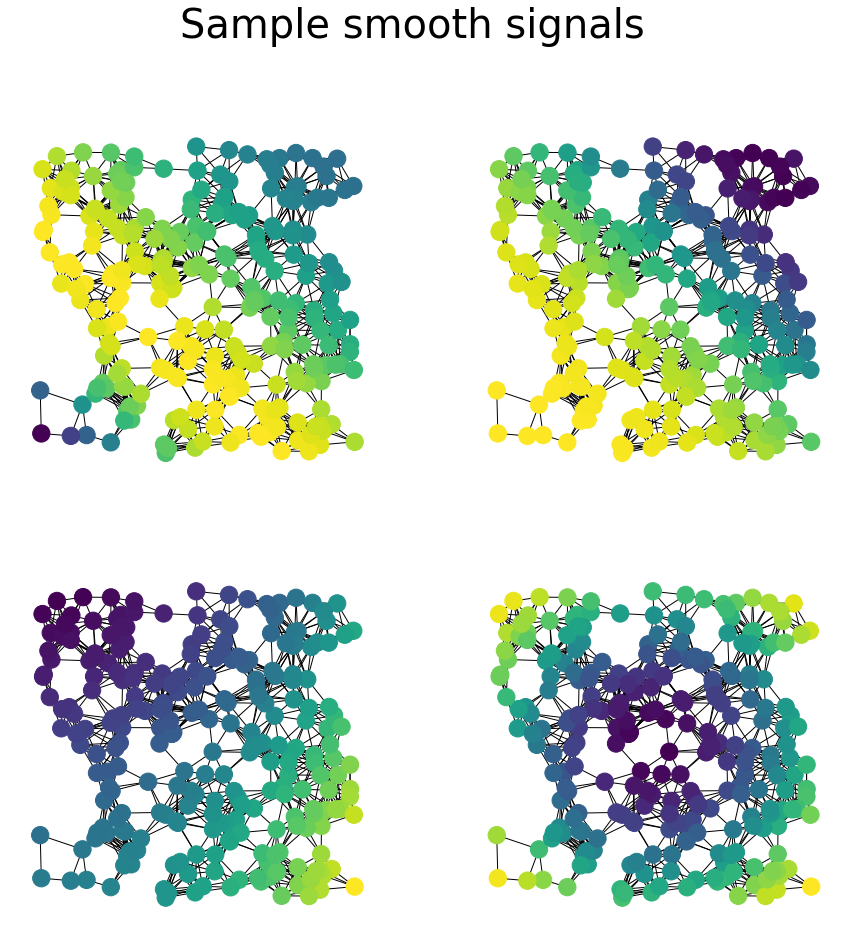

In [129]:
plt.figure(figsize=(15, 15))
plt.suptitle('Sample smooth signals', fontsize=40)

plt.subplot(2,2,1)
nx.draw(G_nx, pos=pos, node_color=X[:,0])

plt.subplot(2,2,2)
nx.draw(G_nx, pos=pos, node_color=X[:,1])

plt.subplot(2,2,3)
nx.draw(G_nx, pos=pos, node_color=X[:,2])

plt.subplot(2,2,4)
nx.draw(G_nx, pos=pos, node_color=X[:,3])

## Solve the optimization problem

In [130]:
# Solve the problem
W, problem = lg.l2_degree_reg(X, dist_type='sqeuclidean', alpha=1, s=N, retall=True, verbosity='LOW')

Solution found after 346 iterations:
    objective function f(sol) = 4.153233e+02
    stopping criterion: RTOL


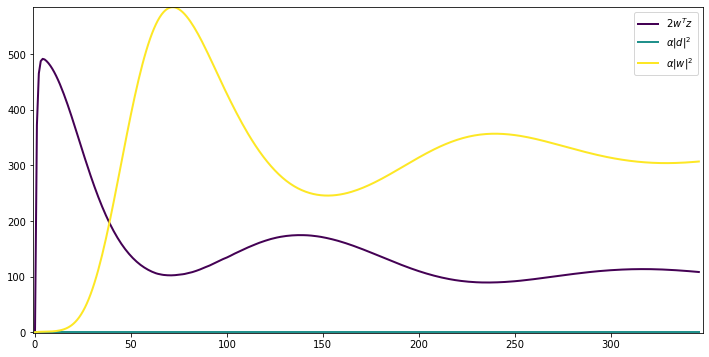

In [131]:
# Display objective values
fig, ax = utils.plot_objectives(problem['objective'], 
                                labels=[r'$2 w^T z$', 
                                        r'$\alpha \|d\|^2$',
                                        r'$\alpha \|w\|^2$'])
#ax.set_xlim([-1, 100])
#ax.set_ylim([-500, 2500])
plt.show()

## Recover learned graph

In [132]:
W_thresh = np.max(W_gt) * W / np.max(W)
W_thresh[W_thresh < 0.1 * np.max(W_gt)] = 0
G_learned = nx.from_numpy_matrix(W_thresh)

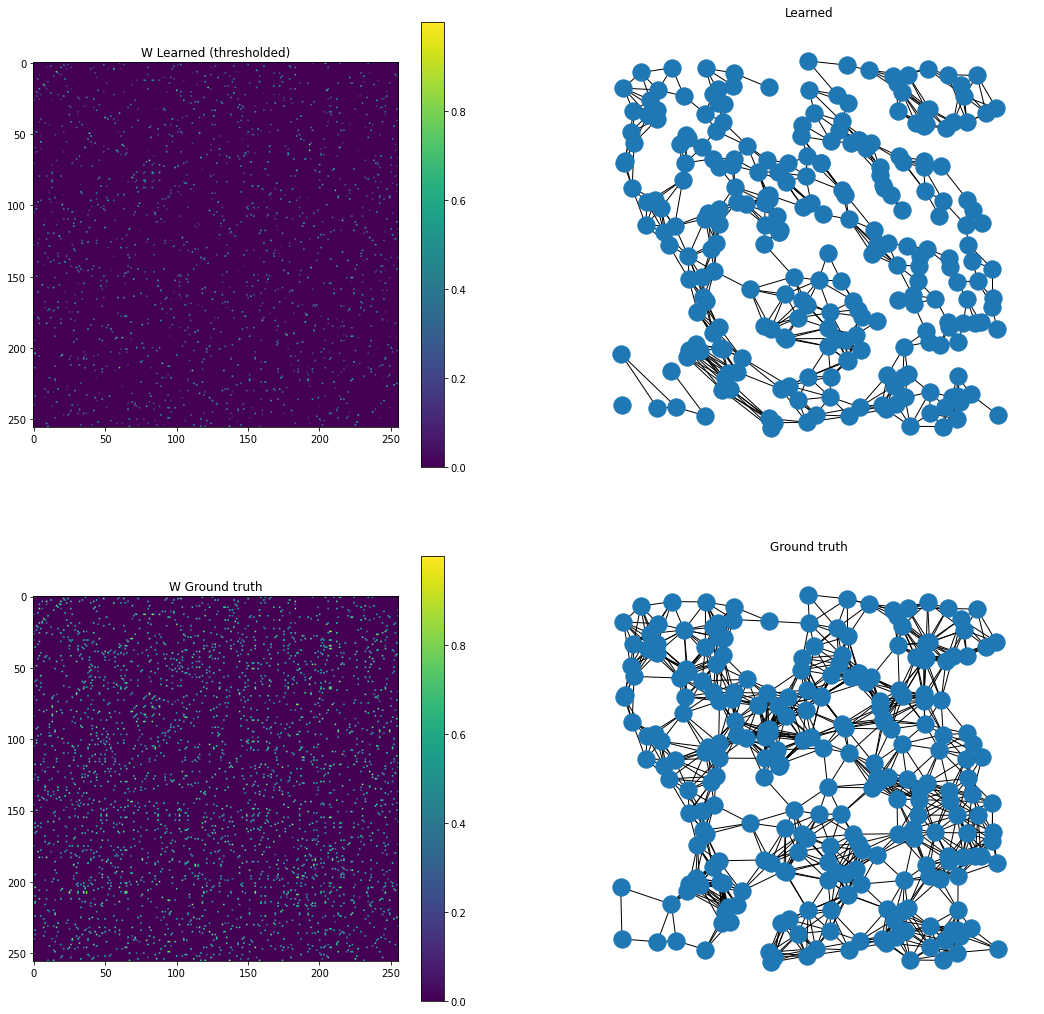

In [133]:
plt.figure(figsize=(18, 18))
plt.subplot(2,2,1)
plt.imshow(W_thresh)
plt.colorbar()
plt.title('W Learned (thresholded)')

plt.subplot(2,2,2)
nx.draw(G_learned, pos=pos)
plt.title('Learned')

plt.subplot(2,2,3)
plt.imshow(W_gt)
plt.colorbar()
plt.title('W Ground truth')

plt.subplot(2,2,4)
nx.draw(G_nx, pos=pos)
plt.title('Ground truth')

plt.show()

In [134]:
f_score = metrics.f1_score((spatial.distance.squareform(W_gt) > 0), 
                           (spatial.distance.squareform(W) > 0))
print("F-score = {:.2f}".format(f_score))

F-score = 0.09


## Compare spectra of the Laplacian matrices

In [135]:
L = utils.create_laplacian(W, lap_type='normalized', 
                           sparse_flag=False)
L_gt = utils.create_laplacian(W_gt, lap_type='normalized', 
                           sparse_flag=False)
e, _ = np.linalg.eigh(L)
e = np.sort(e)
e_gt, _ = np.linalg.eigh(L_gt)
e_gt = np.sort(e_gt)

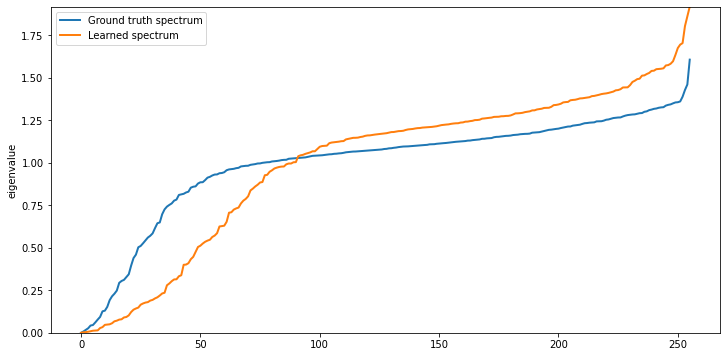

In [124]:
plt.figure(figsize=(12, 6))
plt.plot(e_gt, linewidth=2)
plt.plot(e, linewidth=2)
plt.ylabel('eigenvalue')
plt.ylim([0,max(np.max(e_gt), np.max(e))])
plt.legend(['Ground truth spectrum', 'Learned spectrum'], loc='best')

plt.show()